In [94]:
# Load libraries
import torch 
import pandas as pd 
import numpy as np
import json
import tokenizers
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import seaborn as sns


from torch import tensor
from torch.utils.data import DataLoader, Dataset
from transformers import  RobertaConfig
from tokenizers.implementations import ByteLevelBPETokenizer
from tokenizers.models import WordLevel, BPE
from tokenizers import pre_tokenizers, normalizers, Tokenizer
from tokenizers.normalizers import Lowercase, NFD
from tokenizers.pre_tokenizers import ByteLevel, Whitespace
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.decomposition import PCA 
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from utils.utils import prob2label
from mpl_toolkits.mplot3d import Axes3D
from collections import defaultdict
from tqdm import tqdm


In [48]:
# Load settings
with open("settings.json","r") as inFile:
    settings = json.load(inFile)
    
# Load train and test dataset and merge
train_dataset = pd.read_csv(settings['file']['train_data'])
test_dataset = pd.read_csv(settings['file']['test_data'])
dataset = pd.concat([train_dataset, test_dataset], axis=0)
dataset

,CDR3a,CDR3b,activated_by,num_label,activatedby_HA,activatedby_HCRT,activatedby_NP,negative,activated_any
0,CILQTQGGSEKLVF,CASSIGTSVAGYTF,NP136,5,0,0,1,0,1
1,CVVSDLPPGGKLIF,CASSTSTGGGQPQHF,HA69,0,1,0,0,0,1
2,CAVKTGGFKTIF,CSAIQGAASYEQYF,NP136,5,0,0,1,0,1
3,CAGDTASKLTF,CASSGTSGTYNEQFF,NP136,5,0,0,1,0,1
4,CAVDRYGNKLVF,CASSRASGFSTDTQYF,HCRT,3,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...
1859,CAVSRGGSNYKLTF,CASSLAGLAVETQYF,negative,6,0,0,0,1,0
1860,CAVRGAQGAQKLVF,CASSPGGTANYEQYF,negative,6,0,0,0,1,0
1861,CAVISNFGNEKLTF,CASSQITGASNEQFF,negative,6,0,0,0,1,0
1862,CAASIQGGSEKLVF,CASSWGLAQETQYF,NP136,5,0,0,1,0,1


In [76]:
# Init
AA_alpha, AA_beta = defaultdict(list), defaultdict(list)
AA_df_alpha, AA_df_beta = pd.DataFrame(columns=["AA","position","activated_by"]), pd.DataFrame(columns=["AA","position","activated_by"])

# Iterate over all chains to find AA position distribution
for row in tqdm(dataset.iterrows()):
    
    for idx, AA in enumerate(row[1].CDR3a):
        AA_alpha[AA] += [idx/len(row[1].CDR3a)]    
        AA_df_alpha = AA_df_alpha.append({"AA":AA, "position":idx/len(row[1].CDR3a), "activated_by":row[1].activated_by}, ignore_index=True)    
    for idx, AA in enumerate(row[1].CDR3b):
        AA_beta[AA] += [idx/len(row[1].CDR3b)]
        AA_df_beta = AA_df_beta.append({"AA":AA, "position":idx/len(row[1].CDR3b), "activated_by":row[1].activated_by}, ignore_index=True)    

6181it [10:04, 10.22it/s]


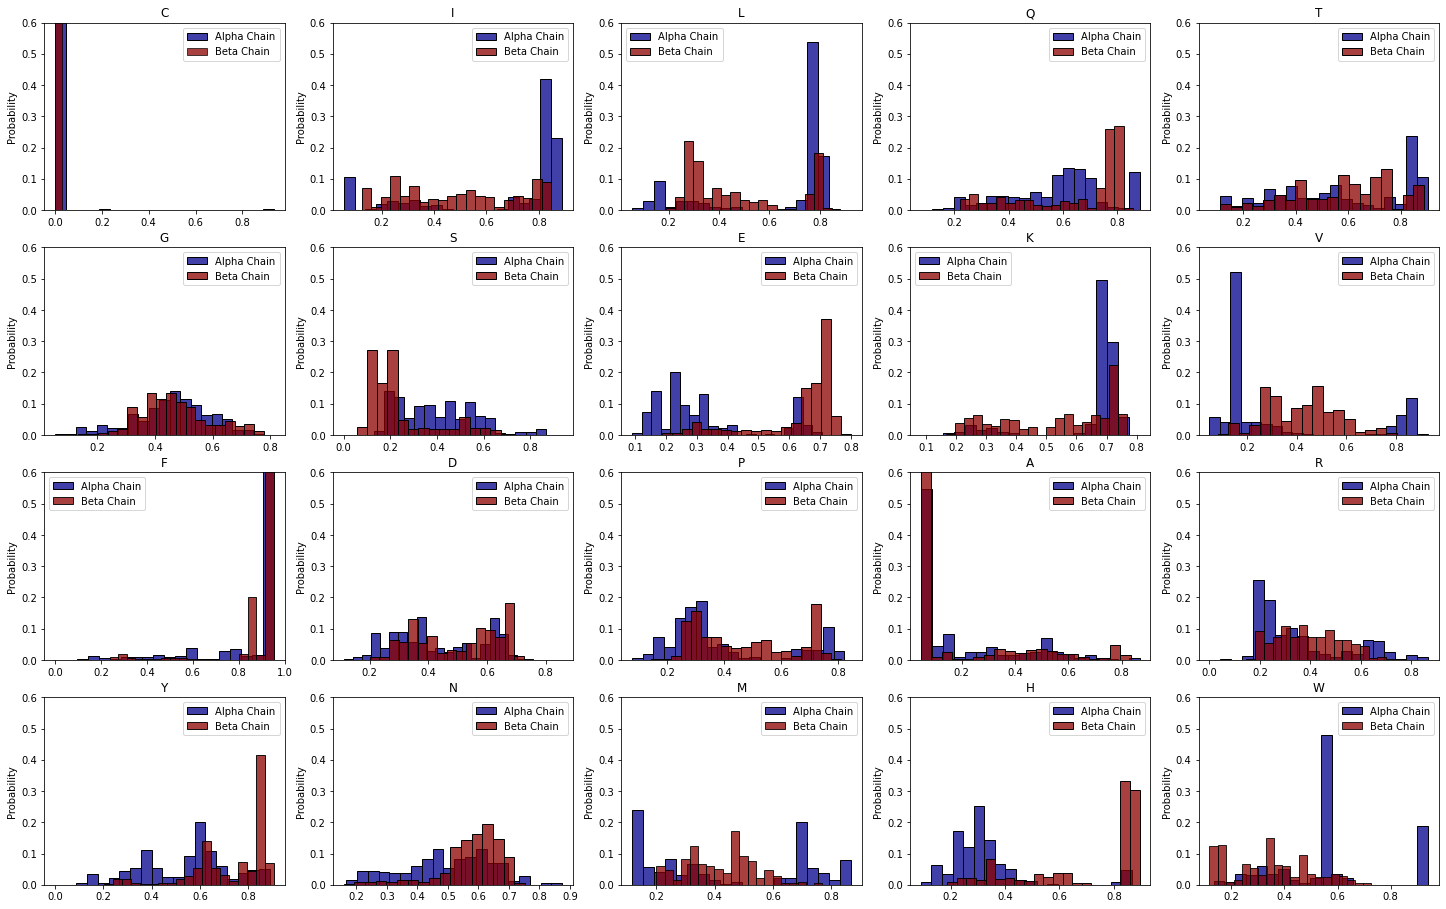

In [55]:
%matplotlib inline
fig = plt.figure(1, figsize=(25,20))
for idx, AA in enumerate(AA_alpha.keys()):
    plt.subplot(5,5,idx+1)
    sns.histplot(AA_alpha[AA], kde=False, color = 'darkblue', stat="probability", bins=20)
    plt.ylim(0, 0.6)
    sns.histplot(AA_beta[AA], kde=False, color = 'darkred', stat="probability", bins=20)
    plt.ylim(0, 0.6)
    plt.legend(labels=["Alpha Chain","Beta Chain"])
    plt.title(AA)
plt.show()

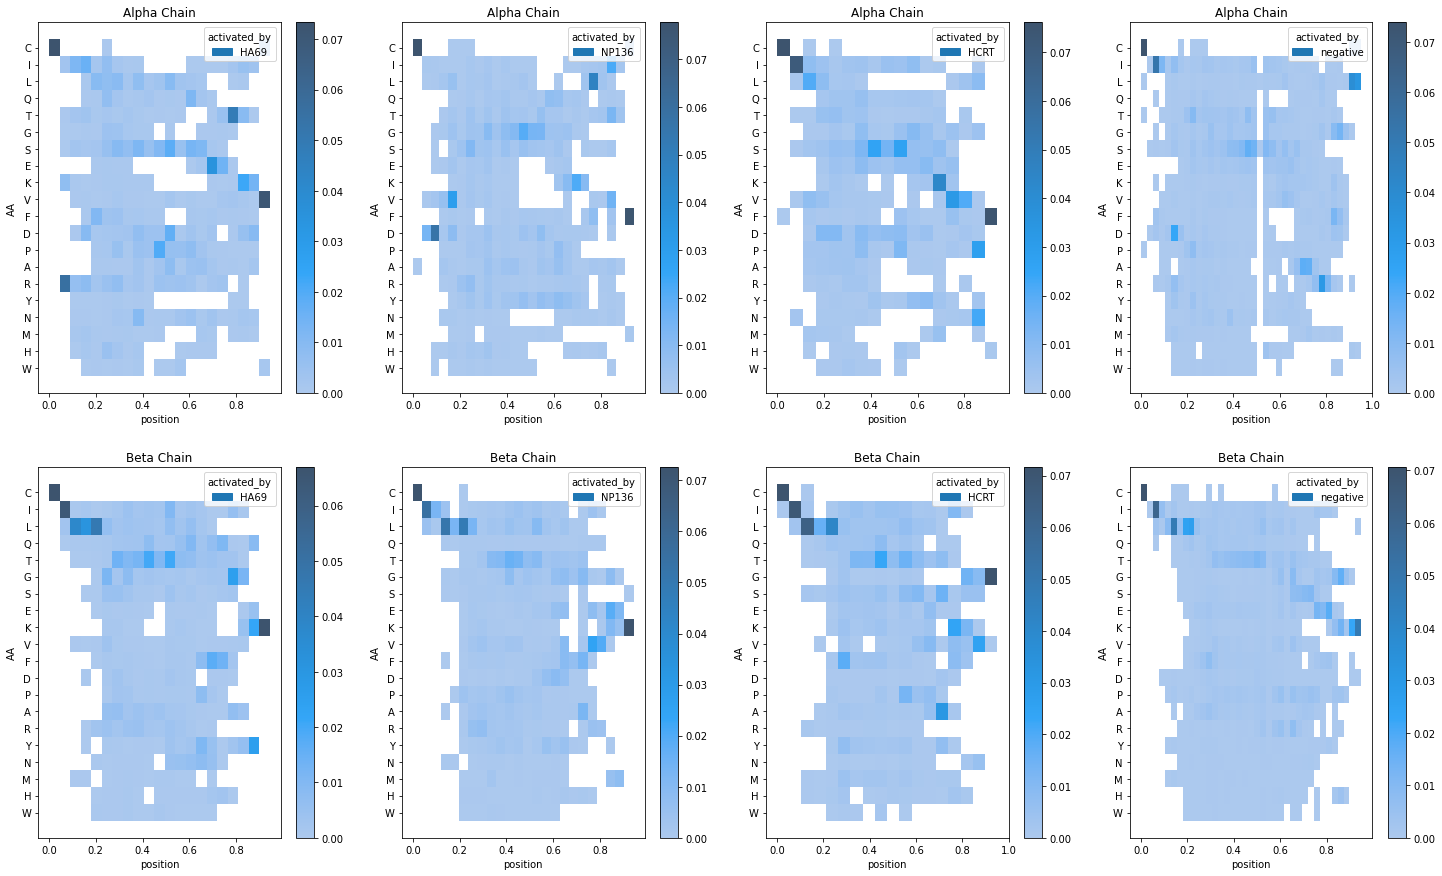

In [104]:
%matplotlib inline
fig = plt.figure(1, figsize=(25,15))
for idx, peptide in enumerate(["HA69", "NP136", "HCRT", "negative"]):
    plt.subplot(2,4,idx+1)
    g = sns.histplot(AA_df_alpha[AA_df_alpha.activated_by == peptide],
                    x="position", y = "AA", hue="activated_by", stat="probability", discrete=(False, True), cbar=True)
    g.set_yticks(range(len(list(AA_alpha.keys()))))
    g.set_yticklabels(list(AA_alpha.keys()))
    plt.title("Alpha Chain")
for idx, peptide in enumerate(["HA69", "NP136", "HCRT", "negative"]):
    plt.subplot(2,4,idx+5)
    g = sns.histplot(AA_df_beta[AA_df_beta.activated_by == peptide],
                    x="position", y = "AA", hue="activated_by", stat="probability", discrete=(False, True), cbar=True)
    g.set_yticks(range(len(list(AA_alpha.keys()))))
    g.set_yticklabels(list(AA_alpha.keys()))
    plt.title("Beta Chain")

